In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import pickle
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance

import sys
import os
from tqdm import tqdm

RAND = 10
N_FOLDS = 3
TIMEOUT = 90000

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
model_path = os.path.abspath('../models')
sys.path.append(model_path)
from get_metrics import get_metrics_regression
from check_overfitting import check_overfitting

# Import data

In [46]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

In [47]:
df[:3]

milliseconds                          place     status  tsunami   
0  1668773163070  14 km SSE of Eden Roc, Hawaii  automatic        0  \
1  1668773284487  40 km ESE of Nikolski, Alaska   reviewed        0   
2  1668773482790       45 km SW of Howell, Utah   reviewed        0   

   significance   data_type  magnitude country   longitude   latitude  depth   
0            58  earthquake       1.94     USA -155.030334  19.374001   7.10  \
1            62  earthquake       2.00     USA -168.310800  52.786100  64.90   
2            21  earthquake       1.16     USA -112.845833  41.512167   5.73   

              datetime timezone magnitude_bins  year  month  day  hour   
0  2022-11-18 12:06:03   +00:00          green  2022     11   18    12  \
1  2022-11-18 12:08:04   +00:00          green  2022     11   18    12   
2  2022-11-18 12:11:22   +00:00          green  2022     11   18    12   

   minute  second  
0       6       3  
1       8       4  
2      11      22

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94354 entries, 0 to 94353
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   milliseconds    94354 non-null  int64  
 1   place           94354 non-null  object 
 2   status          94354 non-null  object 
 3   tsunami         94354 non-null  int64  
 4   significance    94354 non-null  int64  
 5   data_type       94354 non-null  object 
 6   magnitude       94354 non-null  float64
 7   country         94354 non-null  object 
 8   longitude       94354 non-null  float64
 9   latitude        94354 non-null  float64
 10  depth           94354 non-null  float64
 11  datetime        94354 non-null  object 
 12  timezone        94354 non-null  object 
 13  magnitude_bins  94354 non-null  object 
 14  year            94354 non-null  int64  
 15  month           94354 non-null  int64  
 16  day             94354 non-null  int64  
 17  hour            94354 non-null 

In [49]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

tsunami  significance     magnitude     longitude      latitude   
count  94354.000000  94354.000000  94354.000000  94354.000000  94354.000000  \
mean       0.000964     67.406363      1.720177   -116.542011     41.560005   
std        0.031041     96.398645      1.178204     72.358151     20.357130   
min        0.000000      0.000000      0.000000   -179.998700    -65.425400   
25%        0.000000     14.000000      0.950000   -153.445775     34.018333   
50%        0.000000     30.000000      1.400000   -122.852500     39.246300   
75%        0.000000     68.000000      2.100000   -116.717375     58.264000   
max        1.000000   2910.000000      7.800000    179.999400     86.593900   

              depth          year         month           day          hour   
count  94354.000000  94354.000000  94354.000000  94354.000000  94354.000000  \
mean      26.813648   2022.824915      5.299479     15.482046     11.486010   
std       56.179701      0.380042      3.429028      8.635858      6.920763   
min       -3.740000   2022.000000      1.000000      1.000000      0.000000   
25%        3.400000   2023.000000      3.000000      8.000000      6.000000   
50%        9.200000   2023.000000      5.000000     16.000000     11.000000   
75%       25.600000   2023.000000      7.000000     23.000000     17.000000   
max      681.238000   2023.000000     12.000000     30.000000     23.000000   

             minute        second  
count  94354.000000  94354.000000  
mean      29.419537     29.468290  
std       17.357370     17.283395  
min        0.000000      0.000000  
25%       14.000000     15.000000  
50%       29.000000     29.000000  
75%       45.000000     44.000000  
max       59.000000     59.000000

In [50]:
# основные описательные статистики для булевых и категориальных признаков
df.describe(include=["object", "bool"])

place    status   data_type country   
count                       94354     94354       94354   94354  \
unique                      34095         3           7     234   
top     8km NW of The Geysers, CA  reviewed  earthquake     USA   
freq                          973     84325       92210   80057   

                   datetime timezone magnitude_bins  
count                 94354    94354          94354  
unique                93284        1              3  
top     2023-03-02 18:11:07   +00:00          green  
freq                      2    94354          82184

# LabelEncoder

In [51]:
# создаем LabelEncoder для кодирования категориальных значений
le = LabelEncoder()

# список категориальных столбцов
categorical_cols = df.select_dtypes(include=[object]).columns

# кодируем каждый категориальный столбец
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

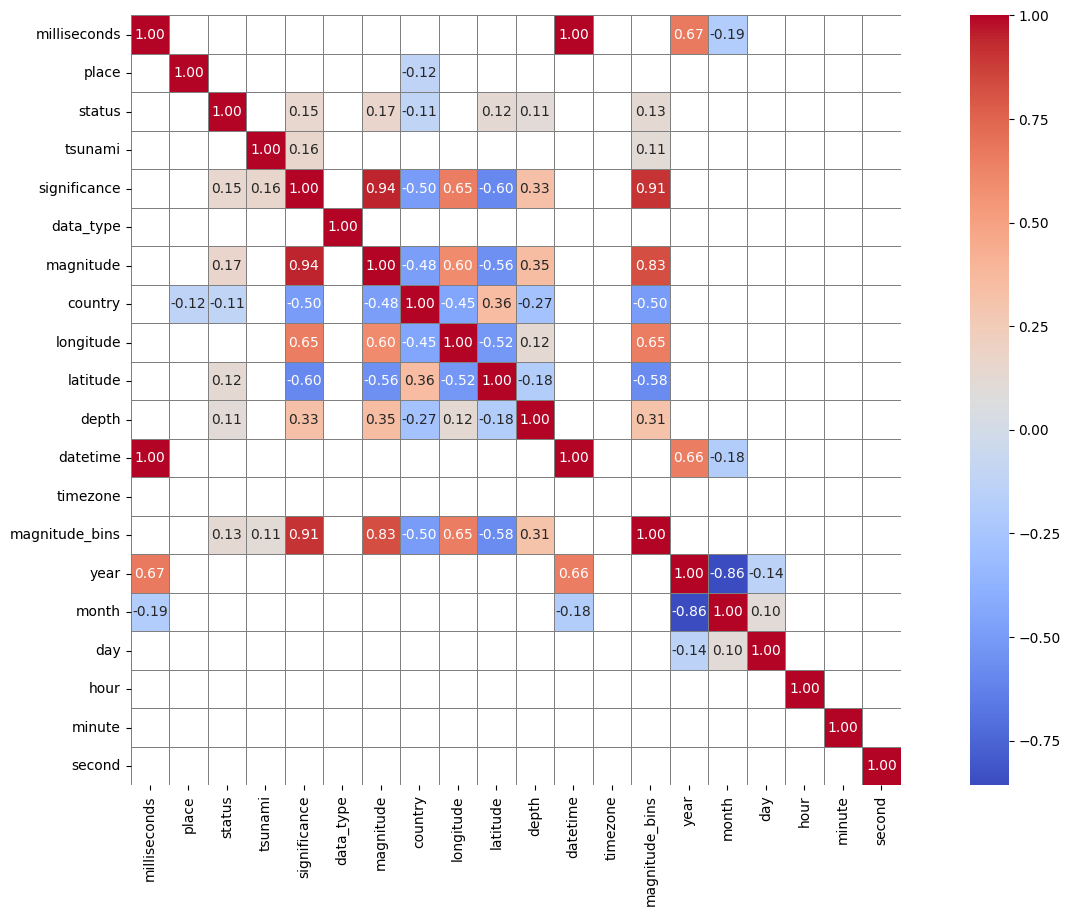

In [52]:
# рассчитываем матрицу корреляции
corr_matrix = df.corr()

# создаем маску
mask = np.abs(corr_matrix) < 0.1

# указывает размер графика
plt.figure(figsize=(18, 10))

# создаем тепловую карту матрицы корреляции
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', mask=mask, linewidths=0.5, linecolor='grey')

# Показываем график
plt.show()

In [53]:
df.columns

Index(['milliseconds', 'place', 'status', 'tsunami', 'significance',
       'data_type', 'magnitude', 'country', 'longitude', 'latitude', 'depth',
       'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

# permutation_importance

In [54]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        # 'magnitude',
        # 'longitude',
        # 'latitude'
        ]]

# целевые переменные
y = df[[
    'magnitude',
    'longitude',
    'latitude'
    ]]

In [55]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

Модель RandomForestRegressor(random_state=10):
['country', 'significance', 'place', 'depth', 'status']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['significance', 'country', 'place', 'depth', 'status', 'magnitude_bins']

Модель DecisionTreeRegressor(random_state=10):
['country', 'significance', 'place', 'depth', 'datetime', 'milliseconds', 'status', 'day', 'hour', 'minute', 'second', 'month']

Общие важные признаки для моделей:
['significance', 'place', 'depth', 'status', 'country']


# разделение данных train_test_split

In [56]:
# признаки из permutation_importance
X = df[list(common_features)]

# целевые переменные
y = df[['magnitude', 'longitude', 'latitude']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RAND)

# Baseline 

## RandomForestRegressor

In [57]:
# модель RandomForestRegressor
rfr = RandomForestRegressor(random_state=RAND)
# обучаем модель
rfr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_rfr = rfr.predict(X_test)

In [58]:
# проверка на переобучение модели RandomForestRegressor
check_overfitting(rfr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 17.636
mean_squared_error test: 126.136
delta = 86.0 %


In [59]:
# просмотр метрик модели RandomForestRegressor обученной на train
metrics = get_metrics_regression(y_test,
                                 y_pred = y_pred_rfr,
                                 X_test = X_test,
                                 name='RandomForestRegressor_Baseline')
metrics

model       MAE         MSE       RMSE RMSLE   
0  RandomForestRegressor_Baseline  2.983354  126.136341  11.231044  None  \

   R2 adjusted  
0     0.947743

## DecisionTreeRegressor

In [60]:
# модель DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=RAND)
# обучаем модель
dtr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_dtr = dtr.predict(X_test)

In [61]:
# проверка на переобучение модели DecisionTreeRegressor
check_overfitting(dtr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 0.360
mean_squared_error test: 202.128
delta = 99.8 %


In [62]:
# просмотр метрик модели DecisionTreeRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_dtr,
                           X_test = X_test,
                           name='DecisionTreeRegressor_Baseline')])
metrics

model       MAE         MSE       RMSE RMSLE   
0  RandomForestRegressor_Baseline  2.983354  126.136341  11.231044  None  \
0  DecisionTreeRegressor_Baseline  3.287990  202.128244  14.217181  None   

   R2 adjusted  
0     0.947743  
0     0.908403

## GradientBoostingRegressor

In [63]:
# модель GradientBoostingRegressor
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND))

# обучаем модель
gbr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_gbr = gbr.predict(X_test)


In [64]:
# проверка на переобучение модели GradientBoostingRegressor
check_overfitting(gbr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 337.248
mean_squared_error test: 328.487
delta = 2.7 %


In [65]:
# просмотр метрик модели GradientBoostingRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_gbr,
                           X_test = X_test,
                           name='GradientBoostingRegressor_Baseline')])
metrics

model       MAE         MSE       RMSE RMSLE   
0      RandomForestRegressor_Baseline  2.983354  126.136341  11.231044  None  \
0      DecisionTreeRegressor_Baseline  3.287990  202.128244  14.217181  None   
0  GradientBoostingRegressor_Baseline  8.312626  328.486730  18.124203  None   

   R2 adjusted  
0     0.947743  
0     0.908403  
0     0.860957

# Optuna & KFold подбор гиперпараметров и кросс-валидация

## RandomForestRegressor

In [66]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # RandomForestRegressor с гиперпараметрами
    rfr = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                bootstrap=bootstrap,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=TIMEOUT)

[I 2024-07-19 03:57:04,935] A new study created in memory with name: no-name-6c46f47c-f8d0-42b4-8db7-0831e342588a
[I 2024-07-19 03:57:16,931] Trial 0 finished with value: -0.27642293812390345 and parameters: {'n_estimators': 328, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.38599112027589716, 'max_features': 9, 'bootstrap': True}. Best is trial 0 with value: -0.27642293812390345.
[I 2024-07-19 03:57:25,110] Trial 1 finished with value: -0.16064256785307682 and parameters: {'n_estimators': 490, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.27331211456784205, 'max_features': 1, 'bootstrap': False}. Best is trial 0 with value: -0.27642293812390345.
[I 2024-07-19 03:58:06,057] Trial 2 finished with value: -0.3654143114348598 and parameters: {'n_estimators': 577, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.26723835313343547, 'max_features': 5, 'boo

In [67]:
# получение лучших гиперпараметров
best_params_rfr = study.best_params

# создание RandomForestRegressor с лучшими гиперпараметрами
rfr_best_params = RandomForestRegressor(**best_params_rfr, random_state=RAND)

# обучение модели
rfr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_rfr_best_params = rfr_best_params.predict(X_test)

In [68]:
# оценка модели
check_overfitting(rfr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_rfr_best_params,
                           X_test=X_test,
                           name='RandomForestRegressor_best_params_optuna')])
metrics

mean_squared_error train: 184.820
mean_squared_error test: 199.275
delta = 7.3 %


model       MAE         MSE       RMSE   
0            RandomForestRegressor_Baseline  2.983354  126.136341  11.231044  \
0            DecisionTreeRegressor_Baseline  3.287990  202.128244  14.217181   
0        GradientBoostingRegressor_Baseline  8.312626  328.486730  18.124203   
0  RandomForestRegressor_best_params_optuna  5.755721  199.274779  14.116472   

  RMSLE  R2 adjusted  
0  None     0.947743  
0  None     0.908403  
0  None     0.860957  
0  None     0.861754

## DecisionTreeRegressor

In [69]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 5)

    # DecisionTreeRegressor с гиперпараметрами
    rfr = DecisionTreeRegressor(splitter=splitter,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=TIMEOUT)

[I 2024-07-19 06:36:08,378] A new study created in memory with name: no-name-ceb91b61-2b17-4fbd-a8e7-08b03de9375e
[I 2024-07-19 06:36:08,480] Trial 0 finished with value: -0.27608602118383024 and parameters: {'splitter': 'best', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.39760428384165203, 'max_features': 4, 'max_leaf_nodes': 5}. Best is trial 0 with value: -0.27608602118383024.
[I 2024-07-19 06:36:08,542] Trial 1 finished with value: -0.0012666079824546793 and parameters: {'splitter': 'random', 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.19118239530033382, 'max_features': 9, 'max_leaf_nodes': 2}. Best is trial 0 with value: -0.27608602118383024.
[I 2024-07-19 06:36:08,637] Trial 2 finished with value: -0.2880956104039975 and parameters: {'splitter': 'best', 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.3738649565439246, 'max_features': 5, 

In [70]:
# получение лучших гиперпараметров
best_params_dtr = study.best_params

# создание RandomForestRegressor с лучшими гиперпараметрами
dtr_best_params = DecisionTreeRegressor(**best_params_dtr, random_state=RAND)

# обучение модели
dtr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_dtr_best_params = dtr_best_params.predict(X_test)

In [71]:
# оценка модели
check_overfitting(dtr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_dtr_best_params,
                           X_test=X_test,
                           name='DecisionTreeRegressor_best_params_optuna')])
metrics

mean_squared_error train: 904.069
mean_squared_error test: 902.130
delta = 0.2 %


model        MAE         MSE       RMSE   
0            RandomForestRegressor_Baseline   2.983354  126.136341  11.231044  \
0            DecisionTreeRegressor_Baseline   3.287990  202.128244  14.217181   
0        GradientBoostingRegressor_Baseline   8.312626  328.486730  18.124203   
0  RandomForestRegressor_best_params_optuna   5.755721  199.274779  14.116472   
0  DecisionTreeRegressor_best_params_optuna  13.765498  902.130466  30.035487   

  RMSLE  R2 adjusted  
0  None     0.947743  
0  None     0.908403  
0  None     0.860957  
0  None     0.861754  
0  None     0.612170

## GradientBoostingRegressor

In [72]:
# целевая функция для оптимизации
def objective(trial):
    # гиперпараметры для настройки
    learning_rate = trial.suggest_float('estimator__learning_rate', 0, 1)
    n_estimators = trial.suggest_int('estimator__n_estimators', 100, 1000)
    subsample = trial.suggest_float('estimator__subsample', 0.1, 1.0)
    min_samples_split = trial.suggest_int('estimator__min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('estimator__min_samples_leaf', 1, 5)
    min_weight_fraction_leaf = trial.suggest_float('estimator__min_weight_fraction_leaf', 0.0, 0.5)
    max_depth = trial.suggest_int('estimator__max_depth', 1, 10)

    # GradientBoostingRegressor с гиперпараметрами
    gbr = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=learning_rate,                                                    
                                                         n_estimators=n_estimators,
                                                         subsample=subsample,
                                                         min_samples_split=min_samples_split,
                                                         min_samples_leaf=min_samples_leaf,
                                                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                                                         max_depth=max_depth,
                                                         random_state=RAND))

    # выполнение кросс-валидации
    scores = cross_val_score(gbr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    return -score  # Optuna минимизирует целевую функцию, поэтому мы используем -score

# выполнение настройки гиперпараметров с Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=TIMEOUT)

[I 2024-07-19 06:36:23,156] A new study created in memory with name: no-name-dc8298f3-f397-4a7e-9065-c691bc4728ef
[I 2024-07-19 06:39:51,205] Trial 0 finished with value: -0.7326109203390684 and parameters: {'estimator__learning_rate': 0.1366197723028849, 'estimator__n_estimators': 548, 'estimator__subsample': 0.8909293734149759, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 5, 'estimator__min_weight_fraction_leaf': 0.12370127446207047, 'estimator__max_depth': 9}. Best is trial 0 with value: -0.7326109203390684.
[I 2024-07-19 06:40:16,930] Trial 1 finished with value: -0.5533850142356328 and parameters: {'estimator__learning_rate': 0.17418897701723035, 'estimator__n_estimators': 150, 'estimator__subsample': 0.4642162321430571, 'estimator__min_samples_split': 4, 'estimator__min_samples_leaf': 1, 'estimator__min_weight_fraction_leaf': 0.20228232295363197, 'estimator__max_depth': 8}. Best is trial 0 with value: -0.7326109203390684.
[I 2024-07-19 06:41:29,341] Trial 2 

In [73]:
# получение лучших гиперпараметров
best_params_gbr = study.best_params

# создание GradientBoostingRegressor с лучшими гиперпараметрами
gbr_best_params = MultiOutputRegressor(GradientBoostingRegressor(**{k.replace('estimator__', ''): v for k, v in best_params_gbr.items()}, random_state=RAND))

# обучение модели
gbr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_gbr_best_params = gbr_best_params.predict(X_test)

In [74]:
# оценка модели
check_overfitting(gbr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_gbr_best_params,
                           X_test=X_test,
                           name='GradientBoostingRegressor_best_params_optuna')])
metrics

mean_squared_error train: 68.956
mean_squared_error test: 128.245
delta = 46.2 %


model        MAE         MSE   
0                RandomForestRegressor_Baseline   2.983354  126.136341  \
0                DecisionTreeRegressor_Baseline   3.287990  202.128244   
0            GradientBoostingRegressor_Baseline   8.312626  328.486730   
0      RandomForestRegressor_best_params_optuna   5.755721  199.274779   
0      DecisionTreeRegressor_best_params_optuna  13.765498  902.130466   
0  GradientBoostingRegressor_best_params_optuna   3.930952  128.244802   

        RMSE RMSLE  R2 adjusted  
0  11.231044  None     0.947743  
0  14.217181  None     0.908403  
0  18.124203  None     0.860957  
0  14.116472  None     0.861754  
0  30.035487  None     0.612170  
0  11.324522  None     0.951955

# Сохранение моделей с лучшими параметрами и метриками

In [85]:
# # сохраняем модель rfr_best_params
# model_file = os.path.join(model_path, 'rfr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(rfr_best_params, f)

# # сохраняем модель dtr_best_params
# model_file = os.path.join(model_path, 'dtr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(dtr_best_params, f)

# # сохраняем модель gbr_best_params
# model_file = os.path.join(model_path, 'gbr_best_params.pkl')
# with open(model_file, 'wb') as f:
#     pickle.dump(gbr_best_params, f)

# # сохранение metrics в файл data/metrics.csv
# metrics.to_csv('../data/metrics.csv', index=False)

# Загрузка моделей с лучшими параметрами

In [76]:
# # загружаем модель rfr_best_params
# with open(os.path.join(model_path, 'rfr_best_params.pkl'), 'rb') as f:
#     rfr_best_params = pickle.load(f)

# # загружаем модель dtr_best_params
# with open(os.path.join(model_path, 'dtr_best_params.pkl'), 'rb') as f:
#     dtr_best_params = pickle.load(f)

# # загружаем модель gbr_best_params
# with open(os.path.join(model_path, 'gbr_best_params.pkl'), 'rb') as f:
#     gbr_best_params = pickle.load(f)

# Функция выбора лучшей модели

In [77]:
metrics

model        MAE         MSE   
0                RandomForestRegressor_Baseline   2.983354  126.136341  \
0                DecisionTreeRegressor_Baseline   3.287990  202.128244   
0            GradientBoostingRegressor_Baseline   8.312626  328.486730   
0      RandomForestRegressor_best_params_optuna   5.755721  199.274779   
0      DecisionTreeRegressor_best_params_optuna  13.765498  902.130466   
0  GradientBoostingRegressor_best_params_optuna   3.930952  128.244802   

        RMSE RMSLE  R2 adjusted  
0  11.231044  None     0.947743  
0  14.217181  None     0.908403  
0  18.124203  None     0.860957  
0  14.116472  None     0.861754  
0  30.035487  None     0.612170  
0  11.324522  None     0.951955

In [78]:
def select_best_model(X_test, y_test, rfr_best_params, dtr_best_params, gbr_best_params):
    """
    Выбирает лучшую модель на основе средней квадратичной ошибки (MSE) на тестовой выборке.

    Параметры:
    - X_test: Тестовые признаки
    - y_test: Тестовая целевая переменная
    - rfr_best_params: Обученная модель случайного леса регрессии
    - dtr_best_params: Обученная модель дерева решений регрессии
    - gbr_best_params: Обученная модель градиентного бустинга регрессии

    Возвращает:
    - Лучшую модель на основе MSE
    """
    models = [rfr_best_params, dtr_best_params, gbr_best_params]
    mse_values = []

    for model in models:
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)

    best_model_index = mse_values.index(min(mse_values))
    best_model = models[best_model_index]

    return best_model

In [79]:
best_model = select_best_model(X_test, y_test, rfr_best_params, dtr_best_params, gbr_best_params)
print("Лучшая модель:", best_model)

Лучшая модель: MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.6634161938681647,
                                                         max_depth=5,
                                                         min_samples_leaf=2,
                                                         min_samples_split=6,
                                                         min_weight_fraction_leaf=0.0006106165539977639,
                                                         n_estimators=565,
                                                         random_state=10,
                                                         subsample=0.9989124331627054))


In [80]:
# предсказания на тестовой выборке лучшей модели
y_pred_best_model = best_model.predict(X_test)

In [81]:
df_y_pred_rfr_best_params = pd.DataFrame(y_pred_rfr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_dtr_best_params = pd.DataFrame(y_pred_dtr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_gbr_best_params = pd.DataFrame(y_pred_gbr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_best_model = pd.DataFrame(y_pred_best_model, columns=['magnitude', 'longitude', 'latitude'])

## Сравнение карт лучшей модели и фактических данных

In [82]:
# создание карты с магнитудой лучшей модели
fig1 = px.scatter_geo(df_y_pred_best_model, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World best vs fact')

fig1.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создание карты с магнитудой реальными данными
fig2 = px.scatter_geo(y_test, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World')

fig2.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создаем subplot
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'geo'}, {'type': 'geo'}]], 
                    subplot_titles=['Earthquakes Around the World best model', 'Earthquakes Around the World fact'])

# добавляем карты в subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# обновляем layout
fig.update_layout(
    width=1200,  
    height=400,  
)

fig.show()

In [86]:
# создание карты с магнитудой лучшей модели
fig1 = px.scatter_geo(df_y_pred_rfr_best_params, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World best vs fact')

fig1.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создание карты с магнитудой реальными данными
fig2 = px.scatter_geo(y_test, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     title='Earthquakes Around the World')

fig2.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=600,  
    height=400,  
)

# создаем subplot
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'geo'}, {'type': 'geo'}]], 
                    subplot_titles=['Earthquakes Around the World best model', 'Earthquakes Around the World fact'])

# добавляем карты в subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# обновляем layout
fig.update_layout(
    width=1200,  
    height=400,  
)

fig.show()

In [83]:
# # Обратное преобразование масштабированных данных в X_train
# X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

# # Обратное преобразование масштабированных данных в X_test
# X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

In [84]:
# декодирование колонки 'country'
#X_train['country'] = le.inverse_transform(X_train['country'])
#X_test['country'] = le.inverse_transform(X_test['country'])